# Clase 7: detección de objetos

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

En la clase práctica de hoy, resolveremos un problema de detección de objetos con RetinaNet. Específicamente, estaremos interesados en detectar dígitos manuscritos (10 clases distintas) en imágenes de cheques. Los datos se pueden descargar desde el siguiente link: https://www.dropbox.com/s/yf6uhsez5f2rau0/orand-car-with-bbs.zip?dl=0 (la contraseña es *cc7221*). Como el link necesita una contraseña, los datos se descargarán desde Google Drive y no directamente usando wget.

Para montar el contenido de Google Drive en la sesión de Colab, pinchamos el botón de "Activar unidad de Drive" en el menú de la izquierda. Luego podemos usar el comando cp para copiar los datos desde Drive a Colab.


In [ ]:
# Copiamos los datos al entorno de Colab
!mkdir /content/data
%cd /content/data
!cp /content/drive/MyDrive/2021-2/sección_1/06/orand-car-with-bbs.zip .
!unzip -q orand-car-with-bbs.zip
!rm orand-car-with-bbs.zip

/content/data


## Detectron2

Detectron2 es una plataforma que permite resolver problemas de detección de objetos, segmentación semántica, detección de poses y otros problemas de computer vision. Se puede encontrar en el siguiente repositorio: https://github.com/facebookresearch/detectron2. Para entrenar sobre un dataset personalizado, pueden seguir el siguiente tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5. Para ver un listado de los modelos disponibles en Detectron2, pueden revisar el siguiente link: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md (en particular, los que nos importan en este tutorial son aquellos de detección de objetos). 

A continuación, se muestra un ejemplo de uso sobre el dataset de montos en cheques. Esto corresponde a una leve modificación del tutorial mencionado anteriormente.

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 12.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=426d32b9e0197b9acd435358b4064961cc289aacbb32b9c081165db4e28f19a1
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.9 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 58.3 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 130 kB 46.0 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 145 kB 33.5 MB/s 
     |████████████████████████████████| 749 kB 38.6 MB/s 
     |███████████████████████████████

In [ ]:
!python3 -m detectron2.utils.collect_env

----------------------  ----------------------------------------------------------------
sys.platform            linux
Python                  3.7.12 (default, Sep 10 2021, 00:21:48) [GCC 7.5.0]
numpy                   1.19.5
detectron2              0.6 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla K80 (arch=3.7)
Driver version          460.32.03
CUDA_HOME               /usr/local/cuda
Pillow                  7.1.2
torchvision             0.10.0+cu111 @/usr/local/lib/python3.7/dist-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5, 8.0, 8.6
fvcore                  0.1.5.post20211023
iopath                  0.1.9
cv2               

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Generar dataset de dígitos

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import glob
from detectron2.structures import BoxMode

def get_digits_dicts():

    data_dir = "/content/data/orand-car-with-bbs/training/"
    imgs_files = glob.glob(data_dir + "images/*.png")
    #anns_files = glob.glob("./annotations.txt")

    dataset_dicts = []

    # Iteramos sobre todas las imágenes
    for idx, img_file in enumerate(imgs_files):

        # Generamos un diccionario asociado a cada imagen
        record = {}
        height, width = cv2.imread(img_file).shape[:2]

        record["file_name"] = img_file
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        ann_filename = img_file.replace(".png", ".txt")
        ann_filename = ann_filename.replace("images", "annotations")
        # ann_filename = data_dir + ann_filename

        try:
            with open(ann_filename, 'r') as f:
                lines = f.readlines()
                lines = [x.strip() for x in lines]
                lines = [x.replace(' ', '') for x in lines]

        except:
            continue

        for obj in lines:
            label = int(obj.split(":")[0])
            bbox = obj.split(":")[1]
            bbox = bbox.split(",")
            bbox = [int(x) for x in bbox]

            obj = {
                "bbox": bbox,  # [xmin, ymin, w, h]
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": label,
            }    
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [ ]:
data_dicts = get_digits_dicts()
print(f"{len(data_dicts)} imágenes en total")

6370 imágenes en total


In [ ]:
# Ejemplo de diccionario para la primera imagen
data_dicts[0]

{'annotations': [{'bbox': [62, 14, 37, 48],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 3},
  {'bbox': [100, 10, 37, 53],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [159, 9, 32, 46],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 8},
  {'bbox': [192, 8, 35, 49],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1},
  {'bbox': [225, 8, 38, 50],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 7}],
 'file_name': '/content/data/orand-car-with-bbs/training/images/0458_5330477_36817.png',
 'height': 70,
 'image_id': 0,
 'width': 305}

In [ ]:
# Registrar el dataset
DatasetCatalog.register("digits", get_digits_dicts)
MetadataCatalog.get("digits").set(thing_classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
digits_metadata = MetadataCatalog.get("digits")

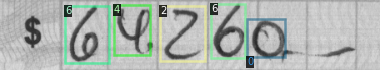

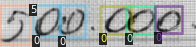

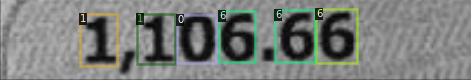

In [ ]:
# Visualizar el dataset
dataset_dicts = get_digits_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=digits_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

### Entrenamiento



In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("digits",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.SOLVER.IMS_PER_BATCH = 16
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.RETINANET.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[10/25 23:34:30 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_bfca0b.pkl: 152MB [00:14, 10.6MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (90, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (90,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[10/25 23:34:56 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[10/25 23:35:30 d2.utils.events]:  eta: 2:23:30  iter: 19  total_loss: 2.442  loss_cls: 1.503  loss_box_reg: 0.8888  time: 1.7388  data_time: 0.0162  lr: 4.9953e-06  max_mem: 2186M
[10/25 23:35:51 d2.utils.events]:  eta: 1:52:54  iter: 39  total_loss: 1.862  loss_cls: 1.174  loss_box_reg: 0.6489  time: 1.3753  data_time: 0.0071  lr: 9.9902e-06  max_mem: 2186M
[10/25 23:36:10 d2.utils.events]:  eta: 1:30:48  iter: 59  total_loss: 1.656  loss_cls: 1.065  loss_box_reg: 0.5229  time: 1.2403  data_time: 0.0075  lr: 1.4985e-05  max_mem: 2186M
[10/25 23:36:32 d2.utils.events]:  eta: 1:23:55  iter: 79  total_loss: 1.564  loss_cls: 1.096  loss_box_reg: 0.4486  time: 1.1965  data_time: 0.0098  lr: 1.998e-05  max_mem: 2424M
[10/25 23:36:52 d2.utils.events]:  eta: 1:25:25  iter: 99  total_loss: 1.521  loss_cls: 1.114  loss_box_reg: 0.4634  time: 1.1623  data_time: 0.0090  lr: 2.4975e-05  max_mem: 2424M
[10/25 23:37:13 d2.utils.events]:  eta: 1:22:35  iter: 119  total_loss: 1.62  loss_cls: 1.081  l

In [ ]:
!cp -r /content/output /content/drive/MyDrive/2021-2/sección_1/06/

### Inferencia

In [ ]:
%cd /content
!cp -r /content/drive/MyDrive/2021-2/sección_1/06/output .

/content


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
# Select topk candidates before NMS
cfg.MODEL.RETINANET.TOPK_CANDIDATES_TEST = 1000
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

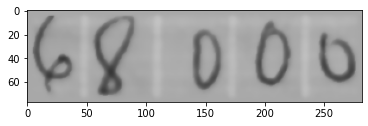

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread("/content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091235157_oQ4HtfShcU-BqOSjyAJ6Zg.bmp")
outputs = predictor(img)
instances = outputs["instances"]
plt.imshow(img)

In [ ]:
instances.pred_classes

tensor([0, 0, 8, 0, 6, 4, 0], device='cuda:0')

In [ ]:
instances.scores

tensor([0.9516, 0.9482, 0.8205, 0.7822, 0.6364, 0.6250, 0.6023],
       device='cuda:0')

In [ ]:
instances.pred_boxes

Boxes(tensor([[136.4402,  12.4119, 166.5641,  66.9533],
        [189.4019,   5.6826, 224.3843,  65.1362],
        [ 53.9374,   2.8276,  91.3529,  71.3000],
        [242.9206,  13.9568, 277.7971,  61.4694],
        [  4.3108,   1.7306,  40.6062,  69.2266],
        [  4.3468,   2.3122,  41.0252,  69.7015],
        [ 53.8167,   3.5188,  92.3223,  72.3886]], device='cuda:0'))

### Visualizar predicciones

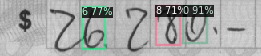

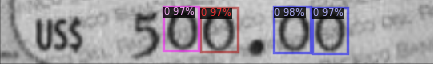

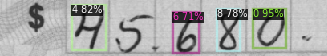

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_digits_dicts()
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=digits_metadata, 
                   scale=0.8, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])